In [1]:
%matplotlib inline
import numpy as np
import pandas as p
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set_style("white")
sns.set(style="ticks")
from matplotlib import rc
rc('text', usetex=True)
sns.set_color_codes()

In [2]:
all_data = p.read_csv('../data/newleaf_compiled_data.csv',index_col=0,dtype={'motif':str})

In [3]:
motif10000 = all_data[all_data['motif'] == '10000']
motif00001 = all_data[all_data['motif'] == '00001']

In [4]:
motif10000_strands = motif10000[(motif10000['maxstrandlen'] == 7) &  (motif10000['elong'] == 0.05) & (motif10000['cells'] == 100)]
motif00001_strands = motif00001[(motif00001['maxstrandlen'] == 7) &  (motif00001['elong'] == 0.05) & (motif00001['cells'] == 100)]
motif10000_cells = motif10000[(motif10000['maxstrandlen'] == 7) &  (motif10000['elong'] == 0.05) & (motif10000['strands'] == 100)]
motif00001_cells = motif00001[(motif00001['maxstrandlen'] == 7) &  (motif00001['elong'] == 0.05) & (motif00001['strands'] == 100)]
motif10000_maxsl = motif10000[(motif10000['strands'] == 100) &  (motif10000['elong'] == 0.05) & (motif10000['cells'] == 100)]
motif00001_maxsl = motif00001[(motif00001['strands'] == 100) &  (motif00001['elong'] == 0.05) & (motif00001['cells'] == 100)]
motif10000_bigcell = motif10000[(motif10000['strands'] == 10000) &  (motif10000['elong'] == 0.05) & (motif10000['cells'] == 1)]
motif00001_bigcell = motif00001[(motif00001['strands'] == 10000) &  (motif00001['elong'] == 0.05) & (motif00001['cells'] == 1)]

In [5]:
import operator as op
def ncr(n, r):
    if r > n: return 0
    r = min(r, n-r)
    if r == 0: return 1
    numer = reduce(op.mul, xrange(n, n-r, -1))
    denom = reduce(op.mul, xrange(1, r+1))
    return numer//denom

def strandlength_distribution(NumCells,r,MaxLength):
    
    b = r
    g = 1/(float(NumCells)+1)
    
    geometric = [( ((b*(1-g))/(b+g*(1-b)))**k * (g/(b+g*(1-b))) ) for k in range(MaxLength)]
    geometric.append(1-sum(geometric))
    
    return geometric

def pull_from_strandlength_distribution(N,NumCells,r,MaxLength):
    
    unifs = np.random.uniform(0,1,N)
    
    geometric = strandlength_distribution(NumCells,r,MaxLength)
    
    geometric_cum = np.cumsum(geometric)
    
    lengths = [np.where(unif < geometric_cum)[0][0] for unif in unifs]
    
    return lengths

def old_motif_freq(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    motiffreq = 0
    for k in range(len(motif),maxLength+1):
        lengthlist = map(''.join, itertools.product('10', repeat=k))

        lengthlist = [string for string in lengthlist if motif in string]
        strand_probs = [b**(s.count('0'))*(1-b)**(s.count('1'))   for s in lengthlist]

        motiffreq = motiffreq + sl_dist[k]*sum([strand_probs[s] for s in range(len(lengthlist)) if motif in lengthlist[s]])
        
    return motiffreq, motiffreq/(1-sl_dist[0])

def motif_freq(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    motiffreq = 0
    motif_containing_strands = [motif]
    last_length = len(motif)
    last_length_list = [motif]
    for k in range(1,maxLength+1-len(motif)):
        # k is non-motif digits
        lengthlist = map(''.join, itertools.product('10', repeat=k))
        
        new_length_0 = [s + '0' for s in last_length_list]
        new_length_1 = [s + '1' for s in last_length_list]
        
        new_length = [s + motif for s in lengthlist]
        
        last_length_list = new_length_0 + new_length_1
        combined = last_length_list + new_length
        last_length_list = list(np.unique(last_length_list + new_length))
        
        motif_containing_strands += last_length_list
        
    strand_probs = [sl_dist[len(s)]*b**(s.count('0'))*(1-b)**(s.count('1'))   for s in motif_containing_strands]

    motiffreq = sum(strand_probs)
        
    return motiffreq, motiffreq/(1-sl_dist[0])


def motif_freq_analytical(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    
    m0 = motif.count('0')
    l = len(motif)
    
    motiffreq = 0
    
    for lam in range(l,maxLength+1):
        this_length_prob = 0
        
        this_length_prob += (lam-l+1)*b**m0*(1-b)**(l-m0)*sum([ncr(lam-l,k)*b**k*(1-b)**(lam-l-k)  for k in range(lam-l+1)])
        if np.floor(lam/l) >= 2:
            for beta in range(2,np.int(np.floor(lam/l))+1):
                this_length_prob +=  sum([(-1)**(beta+1)*ncr(lam-beta*l+beta,beta)*b**(beta*m0)*(1-b)**(beta*(l-m0))*sum([ncr(lam-beta*l,k)*b**k*(1-b)**(lam-beta*l-k) for k in range(lam-beta*l+1)])])

        motiffreq += sl_dist[lam]*this_length_prob
        
    
    return motiffreq, motiffreq/(1-sl_dist[0])

def multiple_overlap_detector(motif):
    l = len(motif)
    o_len = [0]
    o0 = [0]
    for iterator in range(1,l):
        if motif[:l-iterator] == motif[iterator:]:
            o_len.append(l-iterator)
            o0.append(motif[:l-iterator].count('0'))
    if len(o_len) == 0:
        o_len.append(0)
        o0.append(0)
    return o_len, o0

## Analytical Derivation for motifs with multiple overlaps ##
def motif_freq_analytical_multipleoverlap(b,motif,numCells,r,maxLength):
    
    sl_dist = strandlength_distribution(numCells,r,maxLength)
    
    m0 = motif.count('0')
    l = len(motif)
    o_len_list, o0_list = multiple_overlap_detector(motif)


    motiffreq = 0
    
    for lam in range(l,maxLength+1):

        this_length_prob = 0

        for o_len, o0 in zip(o_len_list,o0_list):
            if o_len == 0:
                if np.floor(lam/l) >= 1:
                    for beta in range(1,np.int(np.floor(lam/l))+1):
                        this_length_prob += (-1)**(beta+1)*ncr(lam-beta*l+beta,beta)*b**(beta*m0)*(1-b)**(beta*(l-m0))
            else:
                for alpha in range(1,np.int(np.floor((lam-l-(l-o_len)/l)))+2):

                    if alpha+np.int(np.floor((lam-alpha*l)/(l-o_len))) >= alpha:
                        for beta in range(alpha+1,alpha+np.int(np.floor((lam-alpha*l)/(l-o_len)))+1):

                            this_length_prob += (-1)**(beta+1)*(alpha**(beta-alpha)*ncr(lam-alpha*l-(beta-alpha)*(l-o_len)+alpha,alpha))*b**(alpha*m0+(beta-alpha)*(m0-o0))*(1-b)**(alpha*(l-m0)+(beta-alpha)*(l-m0-(o_len-o0)))

        motiffreq += sl_dist[lam]*this_length_prob
          
    return motiffreq, motiffreq/(1-sl_dist[0])

def cells_with_motif(b,motif,numCells,r,maxLength,numStrands):

    motif_prob = motif_freq_analytical_multipleoverlap(b,motif,numCells,r,maxLength)[0]
    
    p_cell_with_motif = 1-(1-motif_prob)**numStrands
    
    return p_cell_with_motif

def steady_state_motif_dist(b,motif,numCells,r,maxLength,numStrands):
    
    motif_prob, non_empty_motif_freq = motif_freq_analytical_multipleoverlap(b,motif,numCells,r,maxLength)
    
    p_cell_with_motif = 1-(1-motif_prob)**numStrands
    
    p_cell_with_motif = cells_with_motif(0.5,motif,numCells,r,maxLength,numStrands)
    
    ss_motif_freq = p_cell_with_motif*non_empty_motif_freq
    
    return ss_motif_freq    

/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._ed

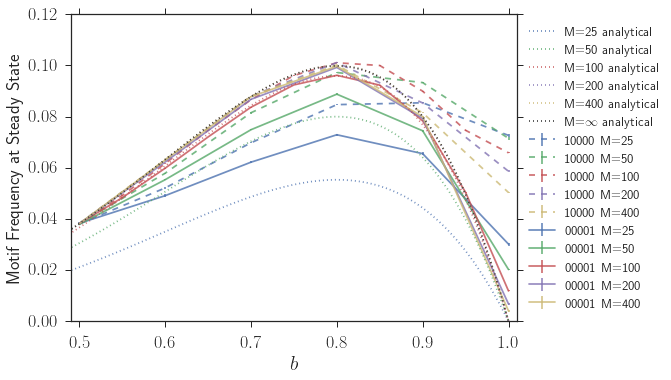

In [6]:
plt.figure()
for value in np.unique(motif10000_strands['strands'].values):
    moment = motif10000_strands[motif10000_strands['strands'] == value]
    biaslist = moment['bias'].values
    biaslist = biaslist[(biaslist > 0.49)]
    biaslist = np.sort(biaslist)
#     print biaslist
    meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
    cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
    plt.errorbar(biaslist,meanlist,yerr=cilist,linestyle='--',label='10000 M=' + str(value),alpha=0.8)
plt.gca().set_color_cycle(None)
for value in np.unique(motif00001_strands['strands'].values):
    moment = motif00001_strands[motif00001_strands['strands'] == value]
    biaslist = moment['bias'].values
    biaslist = biaslist[(biaslist > 0.49)]
    biaslist = np.sort(biaslist)
#     print biaslist
    meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
    cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
    plt.errorbar(biaslist,meanlist,yerr=cilist,label='00001 M=' + str(value),alpha=0.8)
plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'10000',100,0.05,7,25) for b in np.linspace(0.0,1,100)],'b',linestyle=':',label='M=25 analytical',alpha=0.8)
plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'10000',100,0.05,7,50) for b in np.linspace(0.0,1,100)],'g',linestyle=':',label='M=50 analytical',alpha=0.8)
plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'10000',100,0.05,7,100) for b in np.linspace(0.0,1,100)],'r',linestyle=':',label='M=100 analytical',alpha=0.8)
plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'10000',100,0.05,7,200) for b in np.linspace(0.0,1,100)],'m',linestyle=':',label='M=200 analytical',alpha=0.8)
plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'10000',100,0.05,7,400) for b in np.linspace(0.0,1,100)],'y',linestyle=':',label='M=400 analytical',alpha=0.8)
plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'10000',100,0.05,7,10**100) for b in np.linspace(0.0,1,100)],'k',linestyle=':',label='M=$\infty$ analytical',alpha=0.8)


plt.legend(loc='center left',ncol=1,fontsize=13,bbox_to_anchor=(1, 0.5))
plt.xlim(0.49,1.01)
plt.xlabel(r"$b$",fontsize=20)
plt.ylabel('Motif Frequency at Steady State',fontsize=18)
plt.tick_params(labelsize=18)
# plt.savefig('newleaf_revision_strands.pdf',bbox_inches='tight')

/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


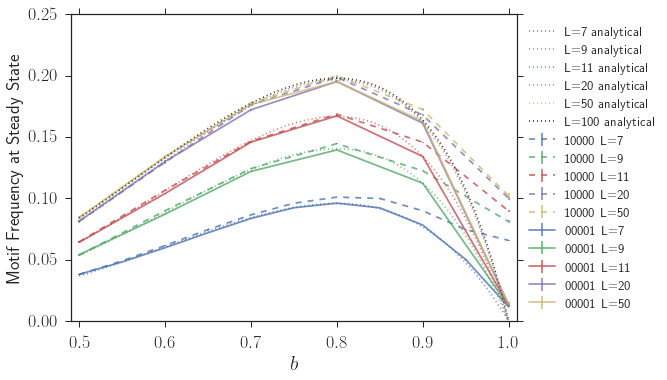

In [74]:
plt.figure()
for value in np.unique(motif10000_maxsl['maxstrandlen'].values):
    moment = motif10000_maxsl[motif10000_maxsl['maxstrandlen'] == value]
    biaslist = moment['bias'].values
    biaslist = biaslist[(biaslist > 0.49)]
    biaslist = np.sort(biaslist)
#     print biaslist
    meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
    cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
    plt.errorbar(biaslist,meanlist,yerr=cilist,linestyle='--',label='10000 L=' + str(value),alpha=0.8)
plt.gca().set_color_cycle(None)
for value in np.unique(motif00001_maxsl['maxstrandlen'].values):
    moment = motif00001_maxsl[motif00001_maxsl['maxstrandlen'] == value]
    biaslist = moment['bias'].values
    biaslist = biaslist[(biaslist > 0.49)]
    biaslist = np.sort(biaslist)
#     print biaslist
    meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
    cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
    plt.errorbar(biaslist,meanlist,yerr=cilist,label='00001 L=' + str(value),alpha=0.8)
plt.plot(np.linspace(0.5,1,100),[steady_state_motif_dist(b,'10000',100,0.05,7,100) for b in np.linspace(0.5,1,100)],'b',linestyle=':',label='L=7 analytical',alpha=0.8)
plt.plot(np.linspace(0.5,1,100),[steady_state_motif_dist(b,'10000',100,0.05,9,100) for b in np.linspace(0.5,1,100)],'g',linestyle=':',label='L=9 analytical',alpha=0.8)
plt.plot(np.linspace(0.5,1,100),[steady_state_motif_dist(b,'10000',100,0.05,11,100) for b in np.linspace(0.5,1,100)],'r',linestyle=':',label='L=11 analytical',alpha=0.8)
plt.plot(np.linspace(0.5,1,100),[steady_state_motif_dist(b,'10000',100,0.05,20,100) for b in np.linspace(0.5,1,100)],'m',linestyle=':',label='L=20 analytical',alpha=0.8)
plt.plot(np.linspace(0.5,1,100),[steady_state_motif_dist(b,'10000',100,0.05,50,100) for b in np.linspace(0.5,1,100)],'y',linestyle=':',label='L=50 analytical',alpha=0.8)
plt.plot(np.linspace(0.5,1,100),[steady_state_motif_dist(b,'10000',100,0.05,100,100) for b in np.linspace(0.5,1,100)],'k',linestyle=':',label='L=100 analytical',alpha=0.8)



plt.legend(loc='center left',ncol=1,fontsize=13,bbox_to_anchor=(1, 0.5))
plt.xlim(0.49,1.01)
plt.xlabel(r"$b$",fontsize=20)
plt.ylabel('Motif Frequency at Steady State',fontsize=18)
plt.tick_params(labelsize=18)
# plt.savefig('newleaf_revision_maxsl_comparision_analytical_plus911_allanalytical.pdf',bbox_inches='tight')

/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


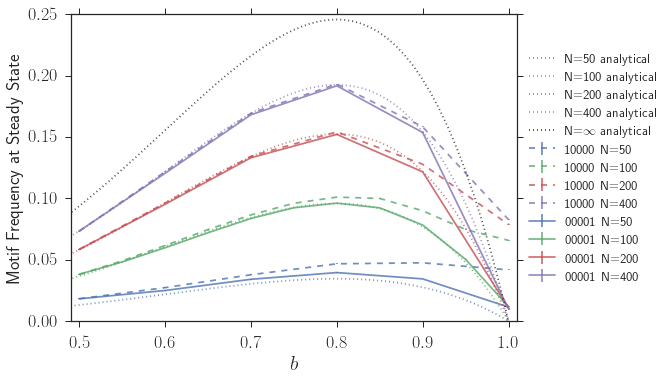

In [76]:
plt.figure()
for value in np.unique(motif10000_cells['cells'].values):
    moment = motif10000_cells[motif10000_cells['cells'] == value]
    biaslist = moment['bias'].values
    biaslist = biaslist[(biaslist > 0.49)]
    biaslist = np.sort(biaslist)
#     print biaslist
    meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
    cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
    plt.errorbar(biaslist,meanlist,yerr=cilist,linestyle='--',label='10000 N=' + str(value),alpha=0.8)
plt.gca().set_color_cycle(None)
for value in np.unique(motif00001_cells['cells'].values):
    moment = motif00001_cells[motif00001_cells['cells'] == value]
    biaslist = moment['bias'].values
    biaslist = biaslist[(biaslist > 0.49)]
    biaslist = np.sort(biaslist)
#     print biaslist
    meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
    cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
    plt.errorbar(biaslist,meanlist,yerr=cilist,label='00001 N=' + str(value),alpha=0.8)
plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'10000',50,0.05,7,100) for b in np.linspace(0.0,1,100)],'b',linestyle=':',label='N=50 analytical',alpha=0.8)
plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'10000',100,0.05,7,100) for b in np.linspace(0.0,1,100)],'g',linestyle=':',label='N=100 analytical',alpha=0.8)
plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'10000',200,0.05,7,100) for b in np.linspace(0.0,1,100)],'r',linestyle=':',label='N=200 analytical',alpha=0.8)
plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'10000',400,0.05,7,100) for b in np.linspace(0.0,1,100)],'m',linestyle=':',label='N=400 analytical',alpha=0.8)
plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'10000',10**100,0.05,7,100) for b in np.linspace(0.0,1,100)],'k',linestyle=':',label='N=$\infty$ analytical',alpha=0.8)

plt.legend(loc='center left',ncol=1,fontsize=13,bbox_to_anchor=(1, 0.5))
plt.xlim(0.49,1.01)
plt.xlabel(r"$b$",fontsize=20)
plt.ylabel('Motif Frequency at Steady State',fontsize=18)
plt.tick_params(labelsize=18)
# plt.savefig('newleaf_revision_cells_comparision_analytical_infty_limiting.pdf',bbox_inches='tight')

In [31]:
motif100 = all_data[all_data['motif'] == '100']
motif001 = all_data[all_data['motif'] == '001']
motif1000 = all_data[all_data['motif'] == '1000']
motif0001 = all_data[all_data['motif'] == '0001']
motif10000_standard = motif10000[(motif10000['maxstrandlen'] == 7) &  (motif10000['elong'] == 0.05) & (motif10000['cells'] == 100) & (motif10000['strands'] == 100)]
motif00001_standard = motif00001[(motif00001['maxstrandlen'] == 7) &  (motif00001['elong'] == 0.05) & (motif00001['cells'] == 100) & (motif00001['strands'] == 100)]

In [32]:
motif10000_standard

,bias,cells,cellswithmotif,cellswithmotif_sd,cellswithmotif_se,elong,maxstrandlen,motif,motiffreq,motiffreq_sd,motiffreq_se,nonemptystrands,nonemptystrands_sd,nonemptystrands_se,nr_samples,rounds,sampler_start,strands,trials
380,0.50,100,0.852160,0.007359,0.001041,0.05,7,10000,0.038028,0.000634,0.000090,0.833450,0.000787,0.000111,50,7000,1000,100,50
381,0.60,100,0.905440,0.005449,0.000771,0.05,7,10000,0.061619,0.000807,0.000114,0.833522,0.000930,0.000132,50,7000,1000,100,50
382,0.70,100,0.934192,0.005129,0.000725,0.05,7,10000,0.086578,0.000957,0.000135,0.833263,0.000847,0.000120,50,7000,1000,100,50
383,0.80,100,0.942684,0.005515,0.000780,0.05,7,10000,0.101025,0.001219,0.000172,0.833269,0.000869,0.000123,50,7000,1000,100,50
384,0.90,100,0.928972,0.003879,0.000549,0.05,7,10000,0.089922,0.001172,0.000166,0.833013,0.000976,0.000138,50,7000,1000,100,50
385,0.55,100,0.882008,0.005859,0.000829,0.05,7,10000,0.049136,0.000584,0.000083,0.833548,0.000905,0.000128,50,7000,1000,100,50
386,0.65,100,0.922144,0.006178,0.000874,0.05,7,10000,0.074584,0.000917,0.000130,0.833276,0.000965,0.000136,50,7000,1000,100,50
387,0.75,100,0.940896,0.003791,0.000536,0.05,7,10000,0.096041,0.000989,0.000140,0.833182,0.000896,0.000127,50,7000,1000,100,50
388,0.85,100,0.941320,0.005127,0.000725,0.05,7,10000,0.099967,0.001184,0.000167,0.833395,0.000830,0.000117,50,7000,1000,100,50
389,0.95,100,0.893872,0.006063,0.000858,0.05,7,10000,0.074625,0.001458,0.000206,0.833237,0.000889,0.000126,50,7000,1000,100,50


/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/I

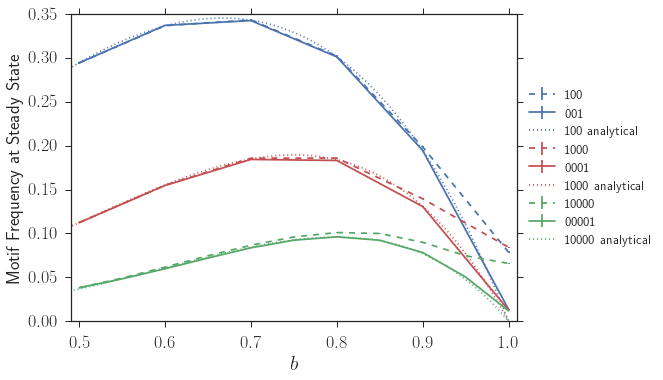

In [77]:
N = 100
plt.figure()
moment = motif100
biaslist = moment['bias'].values
biaslist = np.sort(biaslist[(biaslist > 0.49)])
meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
p100 = plt.errorbar(biaslist,meanlist,yerr=cilist,color='b',linestyle='--',label='100')
plt.gca().set_color_cycle(None)
moment = motif001
biaslist = moment['bias'].values
biaslist = np.sort(biaslist[(biaslist > 0.49)])
meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
p001 = plt.errorbar(biaslist,meanlist,yerr=cilist,color='b',label='001')
plt.gca().set_color_cycle(None)
p100a, = plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'100',100,0.05,7,100) for b in np.linspace(0.0,1,100)],'b',linestyle=':',label='100 analytical')
moment = motif1000
biaslist = moment['bias'].values
biaslist = np.sort(biaslist[(biaslist > 0.49)])
meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
p1000 =plt.errorbar(biaslist,meanlist,yerr=cilist,color='r',linestyle='--',label='1000')
plt.gca().set_color_cycle(None)
moment = motif0001
biaslist = moment['bias'].values
biaslist = np.sort(biaslist[(biaslist > 0.49)])
meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
p0001 =plt.errorbar(biaslist,meanlist,yerr=cilist,color='r',label='0001')
plt.gca().set_color_cycle(None)
p1000a, =plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'1000',100,0.05,7,100) for b in np.linspace(0.0,1,100)],'r',linestyle=':',label='1000 analytical')
moment = motif10000_standard
biaslist = moment['bias'].values
biaslist = np.sort(biaslist[(biaslist > 0.49)])
meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
p10000 =plt.errorbar(biaslist,meanlist,yerr=cilist,color='g',linestyle='--',label='10000')
plt.gca().set_color_cycle(None)
moment = motif00001_standard
biaslist = moment['bias'].values
biaslist = np.sort(biaslist[(biaslist > 0.49)])
meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
p00001 =plt.errorbar(biaslist,meanlist,yerr=cilist,color='g',label='00001')
plt.gca().set_color_cycle(None)
N = 100
p10000a, =plt.plot(np.linspace(0.0,1,100),[steady_state_motif_dist(b,'10000',100,0.05,7,100) for b in np.linspace(0.0,1,100)],'g',linestyle=':',label='10000 analytical')
plt.legend([p100,p001,p100a,p1000,p0001,p1000a,p10000,p00001,p10000a],['100','001','100 analytical','1000','0001','1000 analytical','10000','00001','10000 analytical']\
           ,loc='center left',ncol=1,fontsize=13,bbox_to_anchor=(1, 0.5))
plt.xlim(0.49,1.01)
plt.xlabel(r"$b$",fontsize=20)
plt.ylabel('Motif Frequency at Steady State',fontsize=18)
plt.tick_params(labelsize=18)
# plt.savefig('newleaf_revision_motiflength_comparision_analytical_new_legendfixed.pdf',bbox_inches='tight')

/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/grantkinsler/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


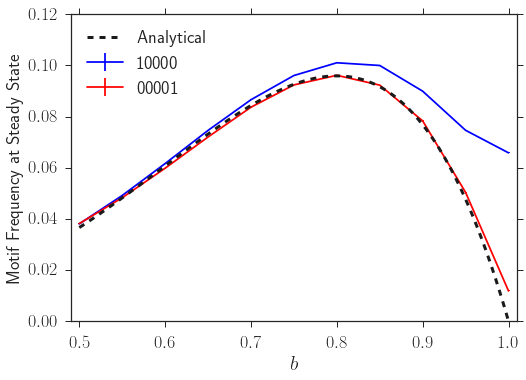

In [73]:
# sns.reset_orig()
# sns
plt.figure()
motif10000original = motif10000_strands[motif10000_strands['strands']==100]
motif00001original = motif00001_strands[motif00001_strands['strands']==100]
moment = motif10000original
biaslist = moment['bias'].values
biaslist = biaslist[(biaslist > 0.49)]
biaslist = np.sort(biaslist)
#     print biaslist
meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
plt.errorbar(biaslist,meanlist,yerr=cilist,color='#0000FF',label='10000')
# plt.gca().set_color_cycle(None)
moment = motif00001original
biaslist = moment['bias'].values
biaslist = biaslist[(biaslist > 0.49)]
biaslist = np.sort(biaslist)
#     print biaslist
meanlist = [moment[moment['bias'] == bias]['motiffreq'].values[0]    for bias in biaslist]
#     print meanlist
#     print [moment[moment['bias'] == 0.6]['motiffreq'].values[0]]
cilist = [1.96*moment[moment['bias'] == biaslist[bias]]['motiffreq_se'].values[0]  for bias in biaslist]
plt.errorbar(biaslist,meanlist,yerr=cilist,color='#FF0000',label='00001')
plt.plot(np.linspace(0.5,1,100),[steady_state_motif_dist(b,'10000',100,0.05,7,100) for b in np.linspace(0.5,1,100)],'k',linestyle='--',linewidth=3,label='Analytical')
plt.legend(loc='upper left',ncol=1,fontsize=1)
plt.xlim(0.49,1.01)
plt.xlabel(r"$b$",fontsize=20)
plt.ylabel('Motif Frequency at Steady State',fontsize=18)
plt.tick_params(labelsize=18)
# plt.savefig('10000v00001_w_analytical_corrected.pdf',bbox_inches='tight')